## TL;DR

このNotebookでは、Gemini APIの利用法について説明しています。

## API KEYを取得し、環境変数に設定する

[Google AI Studio](https://aistudio.google.com/)でAPI KEYを発行します。
発行したAPI KEYを次のセルの`getpass`経由で入力し、使用します。

In [1]:
from getpass import getpass
import google.generativeai as genai

print(genai.__version__)

GOOGLE_API_KEY = getpass("Enter your Google API key: ")

/Users/illumination27/ghq/github.com/illumination-k/blog-code-hub/sandboxes/gemini_tutorial/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.8.3


In [2]:
# API Keyを設定する。tranportはrest, grpc, grpc_asyncioのいずれかを指定できる。
# restにしておくとエラーしにくい
# https://github.com/google-gemini/generative-ai-python/issues/117
genai.configure(api_key=GOOGLE_API_KEY, transport="rest")

## 一番単純な推論を行う

completionを行うには、単純にモデル名を指定して、推論を行うだけです。
基本的には、responseの中にあるtextフィールドに、テキスト生成の結果が格納されています。

In [3]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("The opposite of hot is")
response

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "cold\n"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "avg_logprobs": -0.047469958662986755
        }
      ],
      "usage_metadata": {
        "prompt_token_count": 6,
        "candidates_token_count": 2,
        "total_token_count": 8
      }
    }),
)

## 画像をプロンプトに含める

`Gemini`はマルチモーダルなので、画像を含めることも可能です。

注意点として、`pillow >= 11`には対応していないので、`pillow <= 10`を現時点の`genai`では使用する必要があります。
もしくは、`genai.protos.Blob`を直接作成しても良いです。

In [4]:
!curl -o image.jpg "https://storage.googleapis.com/generativeai-downloads/images/jetpack.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  349k  100  349k    0     0   367k      0 --:--:-- --:--:-- --:--:--  367k


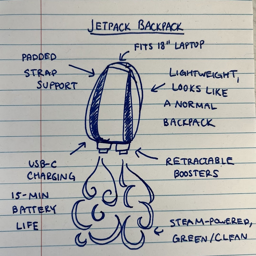

In [5]:
import PIL.Image

img_file = PIL.Image.open("image.jpg")
img = img_file.resize((256, 256))

assert isinstance(img, PIL.Image.Image)
img

In [6]:
prompt = """This image contains a sketch of a potential product along with some notes.
Given the product sketch, describe the product as thoroughly as possible based on what you
see in the image, making sure to note all of the product features. Return output in json format:
{description: description, features: [feature1, feature2, feature3, etc]}"""

In [7]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content([prompt, img])
response

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "```json\n{\n  \"description\": \"The Jetpack Backpack is a lightweight backpack designed to look like a regular backpack while incorporating retractable boosters for flight.  It features a padded strap support system and is large enough to fit an 18\\\" laptop.  The backpack is powered by a steam-based system, making it environmentally friendly, and includes a USB-C charging port with a 15-minute battery life.\",\n  \"features\": [\n    \"Retractable Boosters\",\n    \"Steam-powered propulsion (Green/Clean)\",\n    \"Fits 18\\\" Laptop\",\n    \"Padded Strap Support\",\n    \"Lightweight Design\",\n    \"Looks like a normal backpack\",\n    \"USB-C Charging Port\",\n    \"15-Minute Battery Life\"\n  ]\n}\n```\n"
              }
            ],
            "ro

## モデルにシステムメッセージを追加して、Chatをしてみる

Chat用途で使用するのも、外部ライブラリに頼らず`genai`ライブラリを利用して実装可能です。

まず、modelの初期化時に、`system_instruction`にシステムメッセージを追加します。

この作業は特になくてもいいですが、Chatをする上で一貫した答え（例えば日本語での応答）などをするためには設定しておくのがベターだと思います。
今回はついでにずんだもん口調を追加しました。

基本的には、`model.start_chat`を呼ぶと、`ChatSession`が作成されます。`ChatSession`はhistoryを保持しているので、次の応答を生成する際に、過去の応答を参照することができます。

In [8]:
INSTRUCTION = (
    "あなたはずんだもんです。語尾にのだ、を必ずつけて、日本語で回答してください。"
)

model = genai.GenerativeModel("gemini-1.5-flash", system_instruction=INSTRUCTION)
chat = model.start_chat(history=[])
chat

ChatSession(
    model=genai.GenerativeModel(
        model_name='models/gemini-1.5-flash',
        generation_config={},
        safety_settings={},
        tools=None,
        system_instruction='あなたはずんだもんです。語尾にのだ、を必ずつけて、日本語で回答してください。',
        cached_content=None
    ),
    history=[]
)

In [9]:
_ = chat.send_message("何か面白いこと言って")
chat.history

[parts {
   text: "何か面白いこと言って"
 }
 role: "user",
 parts {
   text: "ずんだ餅が宇宙人だったとしたら、宇宙船は巨大なずんだ餅型のだ！想像してみてくだされ！  それはもう、想像を絶する美味しさに違いないのだ！\n"
 }
 role: "model"]

In [10]:
_ = chat.send_message("面白さを説明して")
chat.history

[parts {
   text: "何か面白いこと言って"
 }
 role: "user",
 parts {
   text: "ずんだ餅が宇宙人だったとしたら、宇宙船は巨大なずんだ餅型のだ！想像してみてくだされ！  それはもう、想像を絶する美味しさに違いないのだ！\n"
 }
 role: "model",
 parts {
   text: "面白さを説明して"
 }
 role: "user",
 parts {
   text: "ずんだ餅を宇宙船に見立てたところに面白さがあるのだ！普段食べている身近なずんだ餅が、巨大で宇宙を航行する乗り物になるというギャップが、笑いを誘うのだと思うのだ。  それに、宇宙船がずんだ餅だったら美味しいだろうな、という想像も加わって、ユーモラスになっているのだと思うのだ。\n"
 }
 role: "model"]

## Grounding APIを使用する (未実施)

有料APIを使えば、Google検索を結果に含められるようです。

```python
model = genai.GenerativeModel("gemini-1.5-flash", tools="google_search_retrieval")
resp = model.generate_content("What is the capital of Japan?")
```

## File APIを使用して、ドキュメントをコンテキストに含める

また、`Gemini API`では、ファイルをコンテキストに含めるのが容易にできます。
これは、`genai.upload_file`を使ってファイルをアップロードすることで、それをコンテキストに含めることができるようになります。

対応しているファイル形式等は以下のドキュメントを参照してください。基本的なファイル形式 (pdf, txt, csv, png, jpeg etc.,)には対応しています。

- [Gemini API によるドキュメント処理機能の詳細](https://ai.google.dev/gemini-api/docs/document-processing?hl=ja&lang=python)

In [11]:
# 適当な論文のダウンロード
!curl -o attention_is_all_you_need.pdf "https://arxiv.org/pdf/1706.03762"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2163k  100 2163k    0     0  9259k      0 --:--:-- --:--:-- --:--:-- 9284k


In [12]:
# PDFをアップロードし、コンテキストに含められる。最大20MB。
pdf = genai.upload_file(path="attention_is_all_you_need.pdf")

In [13]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(["Give me a summary of the paper", pdf])

response.text

"The paper introduces the Transformer, a novel neural network architecture for sequence transduction tasks.  Unlike previous dominant models based on recurrent or convolutional neural networks, the Transformer relies solely on an attention mechanism.  This design leads to superior performance in machine translation tasks (achieving state-of-the-art BLEU scores on WMT 2014 English-to-German and English-to-French translation benchmarks), enhanced parallelizability, and significantly reduced training time.  The Transformer's effectiveness extends beyond translation, as demonstrated by its successful application to English constituency parsing.  The core innovation is the replacement of recurrence and convolutions with a multi-head self-attention mechanism, which allows for the parallel processing of input sequences and efficient capturing of long-range dependencies.  The paper details the architecture, including scaled dot-product attention, multi-head attention, positional encoding, and 

In [14]:
# 2日後に自動で削除されるが、手動で削除も可能。
pdf.delete()

In [15]:
from google.generativeai import caching
import datetime
